another way to find xarms - add to points cloud distanse and angle from founded center

then based on this finding xarms and their angles

In [1]:
from pathlib import Path
import csv
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, MultiPoint, Polygon, LineString

In [2]:
#p = Path(r'/home/igor/Documents/some_tools/structure_samples/xyz')   # for linux
p = Path(r'D:\python\some_tools\structure_samples\xyz')

In [3]:
list_of_files = list(p.glob('*.xyz'))
for file in list_of_files:
    print(file.name)

2pole_supp_guys.xyz
3pole_guys.xyz
d-pole_3x.xyz
pole-w-guys_near_substation.xyz
pole_asim_3.xyz
pole_asim_post.xyz
strain_2.xyz
strain_3_lean_lo.xyz
strain_A_dpole.xyz
strain_A_dpole_leaned.xyz
strain_big.xyz
strain_sm.xyz
st_220_5.xyz
st_220_6.xyz
substation.xyz
sus_220_6.xyz
sus_2pole_lean.xyz
sus_5.xyz
sus_big.xyz
sus_guyed_2x_steel.xyz
sus_w_wires.xyz
s_pole.xyz
s_pole_xarms.xyz


In [4]:
from math import sqrt, acos, degrees

def azimuth(a, b):
    # by two points we get azimuth
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    dist = round(sqrt(dx*dx + dy*dy), 2)    # dist a to b

    dx2 = round(abs(dx), 2)
    
    if dist != 0:
        beta = degrees(acos(dx2/dist))
    else: 
        beta = degrees(acos(0))

    if dx > 0:
        if dy < 0:
            angle = 270 + beta
        else:
            angle = 270 - beta
    else:
        if dy < 0:
            angle = 90 - beta
        else:
            angle = 90 + beta

    return round(angle, 1), dist

start

In [5]:
spam_file = p / 'sus_5.xyz'
str = []
with spam_file.open() as f:
        spamreader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC, skipinitialspace=True)
        for row in spamreader:
            str.append(row)
str[:5]

[[1245959.75, 4851979.15, 20.32],
 [1245959.66, 4851979.11, 20.78],
 [1245959.55, 4851979.2, 21.36],
 [1245959.41, 4851979.79, 20.94],
 [1245959.46, 4851979.43, 21.48]]

In [6]:
# to np array and cut 1/3 from grd
np_str = np.array(str)
np_str_cut = np.delete(np_str, np_str[:,2]<((max(np_str[:,2])-min(np_str[:,2]))/3 + min(np_str[:,2])), 0)

In [7]:
#lets find center 
cpoint = MultiPoint(np_str_cut[:,:2]).minimum_rotated_rectangle.centroid

In [8]:
# now add to all the points dist to cpoint and azimuth
b = []
for i in np_str_cut:
    b.append(azimuth((cpoint.x, cpoint.y), (i[0], i[1])))
np_str_dist = np.append(np_str_cut, np.array(b), axis=1)  # new array with azimuth and distance from cpoint 

In [9]:
# delete points that closer than 1m to center
print(len(np_str_dist))
np_str_dist = np.delete(np_str_dist, np_str_dist[:, 4] < 2, 0)
print(len(np_str_dist))

3262
1032


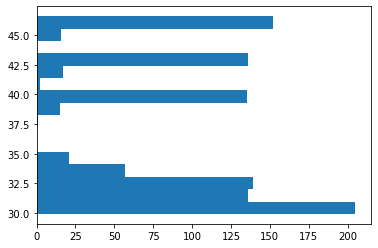

In [10]:
# visualise
new_a = plt.hist(np_str_dist[:, 2], int(max(np_str_dist[:, 2]) - min(np_str_dist[:, 2])), orientation='horizontal')

In [11]:
z_list = sorted(list(set(np_str_dist[:,2])))
for i in range(len(z_list)-1):
    if (z_list[i+1] - z_list[i]) > 0.5:
        gap_start = z_list[i]
        break
gap_start   # это будет линия отреза ног, все что выше - траверсы

35.04

In [12]:
# cut again
np_str_dist = np.delete(np_str_dist, np_str_dist[:,2] < gap_start, 0)
print(len(np_str_dist))

475


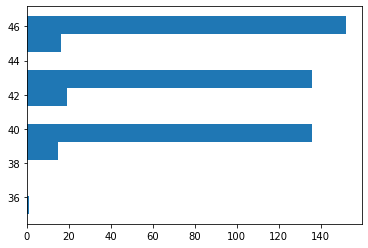

In [132]:
# visualise
new_b = plt.hist(np_str_dist[:,2], int((max(np_str_dist[:,2]) - min(np_str_dist[:,2]))*1), orientation='horizontal')

In [13]:
def xarms_levels(array, segment_size):
    segmented = []
    start = min(array)
    end = start + segment_size
    while end < max(array):
        segmented.append(sum(end > i > start for i in array))
        start += segment_size
        end += segment_size

        
    # then choose only bigger than mean
    ma = []
    biggest = 0
    biggest_nu = 0
    for nu, i in enumerate(segmented):
        if i > (np.mean(segmented)):
            ma.append(round((min(array) + segment_size*nu), 1))
        if i > biggest:
            biggest = i
            biggest_nu = nu
    
    big_one = round((min(array) + segment_size*biggest_nu), 1)
    
    return ma, big_one

In [14]:
# try to split xarms
first_run = xarms_levels(np_str_dist[:,2], 1)[0]   # take 1m step
first_run = sorted(first_run)   # h of xarms after first run

In [16]:
spam = []
for i in range(len(first_run)-1):
    spam.append(first_run[i+1]-first_run[i])
hdist = np.mean(spam)

In [17]:
first_run, spam, hdist

([39.0, 42.0, 45.0], [3.0, 3.0], 3.0)

In [18]:
# then split by arms
arms = []
for i in range(len(first_run)):
    spam = np.delete(np_str_dist, np_str_dist[:,2] < first_run[i], 0)
    if i < len(first_run)-1:
        spam = np.delete(spam, spam[:,2] > first_run[i+1], 0)
    arms.append(spam)


In [19]:
# then work with each arm

In [20]:
# then cut max density on 0.1m
print(len(arms[0]))
level = xarms_levels(arms[0][:,2], 0.1)[1]   # max density
arms[0] = np.delete(arms[0], arms[0][:,2] < level-0.1, 0)
arms[0] = np.delete(arms[0], arms[0][:,2] > level+0.1, 0)
print(len(arms[0]))

154
82


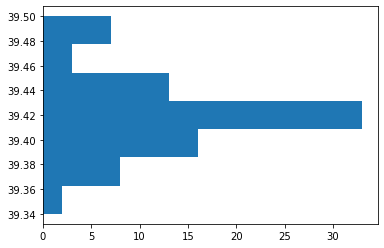

In [236]:
# visualise
new_b = plt.hist(arms[0][:,2], int((max(arms[0][:,2]) - min(arms[0][:,2]))*50), orientation='horizontal')

(1245953.594, 1245956.146, 4851978.1665, 4851984.6235)

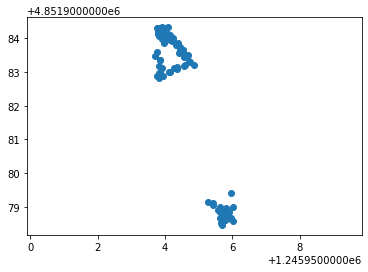

In [239]:
plt.scatter(arms[0][:,0], arms[0][:,1])
plt.axis('equal')

In [255]:
# then select by angle 
# devide to 2 part by angle
# find angle and max len for each part

first_part = []
second_part = []

for i in range(len(arms[0])):
    if i != 0:
        if abs(arms[0][:,3][i]-spam) > 40:
            second_part.append(list(arms[0][i]))
        else:
            first_part.append(list(arms[0][i]))
    else:
        spam = arms[0][:,3][i]
        first_part.append(list(arms[0][i]))

print(len(first_part), len(second_part))


22 60


In [267]:
# cut by length
first_part = np.array(first_part)
first_part = np.delete(first_part, first_part[:,4] < max(first_part[:,4])-0.2, 0)   # cut -0.2 from end

In [320]:
print(np.mean(first_part[:,3]), max(first_part[:,4]))

161.22500000000002 2.8


In [280]:
np.mean(sorted(first_part[:,2])[:5])   # средняя и нижних 5 точек - нижний край траверсы

39.39

In [ ]:
# как финал надо найти ось каждой траверсы (длину, азимут, координаты начала и конца)


In [276]:
second_part = np.array(second_part)
second_part = np.delete(second_part, second_part[:,4] < max(second_part[:,4])-0.2, 0)   # cut -0.2 from end

In [321]:
(np.mean(second_part[:,3]), max(second_part[:,4]))

(340.5357142857143, 3.37)

In [279]:
np.mean(sorted(second_part[:,2]))   # средняя и нижних 5 точек - нижний край траверсы

39.388

In [282]:
max(second_part[:,4]), max(first_part[:,4])

(3.37, 2.8)

In [318]:
from math import cos, sin, radians

def aztocoords(az, length):
    dx = round(sin(radians(az))*length, 2)
    dy = round(cos(radians(az))*length, 2)
    
    return dx, dy

In [322]:
aztocoords(340.5, 3.37)   # sec

(-1.12, 3.18)

In [323]:
aztocoords(161.2, 2.8)  # firts

(0.9, -2.65)

In [325]:
st_p = (cpoint.x - 1.12, cpoint.y + 3.18)

In [327]:
end_p = (cpoint.x + 0.9, cpoint.y - 2.65)

(1245951.938, 1245957.9219999998, 4851977.639, 4851984.700999999)

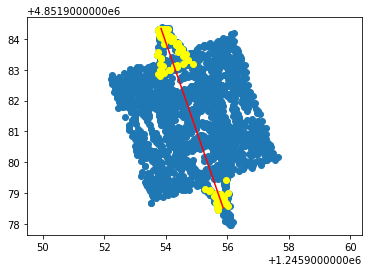

In [336]:
plt.scatter(np_str_cut[:,0], np_str_cut[:,1])
plt.scatter(arms[0][:,0], arms[0][:,1], color='yellow')
plt.plot([(cpoint.x - 1.12), (cpoint.x + 0.9)], [cpoint.y + 3.18, cpoint.y - 2.65], color='red')
plt.axis('equal')